<b>AML2019</b>

<h3>Challenge 1</h3>
<h1>House Pricing Prediction</h1>
<hr style="height:2px;border:none;color:#333;background-color:#333;"/>
<i>22<sup>th</sup> March 2019</i>

The first AML challenge for this year is adapted from the well-known '<i>Zillow's Home Value Prediction</i>' competition on Kaggle.
In particular, given a dataset containing descriptions of homes on the US property market, your task is to make predictions on the selling price of as-yet unlisted properties. 
Developing a model which accurately fits the available training data while also generalising to unseen data-points is a multi-faceted challenge that involves a mixture of data exploration, pre-processing, model selection, and performance evaluation.

# Overview
<hr style="height:1px;border:none;color:#333;background-color:#333;" />    

Beyond simply producing a well-performing model for making predictions, in this challenge we would like you to start developing your skills as a machine learning scientist.
In this regard, your notebook should be structured in such a way as to explore the five following tasks that are expected to be carried out whenever undertaking such a project.
The description below each aspect should serve as a guide for your work, but you are strongly encouraged to also explore alternative options and directions. 
Thinking outside the box will always be rewarded in these challenges.

In [268]:
#####IMPORT ALL NEEDED LIBRABRIES#######
%matplotlib inline
import os
import sys
import re
import random
import matplotlib
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import implicit
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from time import time
os.environ["OPENBLAS_NUM_THREADS"] = "1"   # Required by implicit
base = "/mnt/datasets/lastfm/"
import scipy
from scipy import stats
from scipy.stats import norm, skew #for some statistics

<div class="">
    <h3>1. Data Exploration</h3>
</div>

The first broad component of your notebook should enable you to familiarise yourselves with the given data, an outline of which is given at the end of this challenge specification.
Among others, this section should investigate:

- Data cleaning, e.g. treatment of categorial variables;
- Data visualisation;
- Computing descriptive statistics, e.g. correlation.
- etc.

<div class="alert alert-success">
    <ul><b>
        First, we need to download the data.
        </b>
    </ul>
    </div>

In [269]:
import pandas as pd
import numpy as np

## Read the .csv file with the pandas read_csv method
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
    
train[:5]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [270]:
train.shape

(1200, 81)

In [271]:
test.shape

(260, 80)

<div class="alert alert-success">
    <b>
        We see that we have 81 columns in our train dataset which is a lot. So, when pre-processing the data, we will have to get rid of some of them and keep the most relevant columns related to SalePrice. This is to find a good tradeoff between the computation time and the accuracy of the model.<br>
        The test model has 80 columns: it is missing the SalePrice column that we have to predict.
        </b>
</div>

<div class="alert alert-success">
<b>
By looking at the Data description file, intuitively, we can suppose that the size of the house, the quality of the house and its condition, the neighbourhood, the utilities available and the presence of a garage will impact a lot the price. On the contrary, we can expect that the Masonry veneer type and the Screen porch area in square feet don't impact a lot the SalePrice.
    </b>
    </div>

<div class="alert alert-success">
<b>
        To look at which columns impact the most the SalePrice, we can take a look at the correlation of the different columns with the SalePrice column. The higher the correlation is, the more these colmuns bring information concerning the price.
        </b>
    </div>

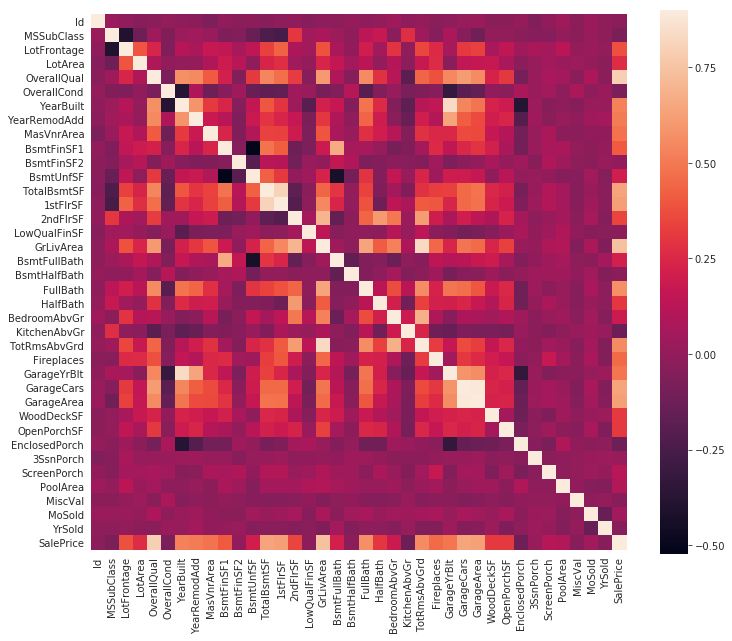

In [272]:
#Correlation map to see how features are correlated with SalePrice
corrmat = train.corr()
plt.subplots(figsize=(12,10))
sns.heatmap(corrmat, vmax=0.9, square=True)
plt.show()

<div class="alert alert-success">
    <b>
        To find the most interesting columns regarding SalePrice, we have to look for the ones which are the most correlated with the latter -appearing light in this graph. <br>
         If we focus on the last row named "SalePrice" and look for the lightest areas, we see that the columns
        <li>OverallQual (Rates the overall material and finish of the house), </li>
        <li>and GrLivArea (Above grade (ground) living area square feet) are the most correlated columns with the column SalePrice.</li>
        Then come the columns
        <li>GarageCars (Size of garage in car capacity),</li>
        <li>GarageArea (Size of garage in square feet),</li>
        <li> TotalBsmtSF (Total square feet of basement area),</li>
        <li> and 1stFlrSF (First Floor square feet).</li>
        Those are the columns we will tend to focus on, to decrease the computation load and keep good results.<br>
        On the contrary, the least correlated columns are, among others (correlation=0):
        <li>Id,</li>
        <li> BsmtFinSF2 (Type 2 finished square feet),</li>
        <li>LowQualFinSF (Low quality finished square feet (all floors)).</li>
        Thus, we will more likely get rid of those columns which don't impact a lot the SalePrice.<br><BR>
          We can raise that some of those results are quite intuitive in the real life.
        </b>
</div>

<div class="alert alert-success">
<b>
    Let's now visualise how the SalePrice varies according to its most correlated column features.
    </b>
    </div>

GrLivArea 0.7403792470454886
TotalBsmtSF 0.6419166279661741
GarageArea 0.6233291704658982
1stFlrSF 0.6185556125238046


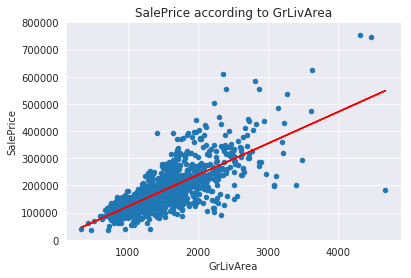

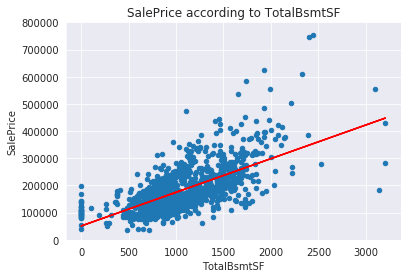

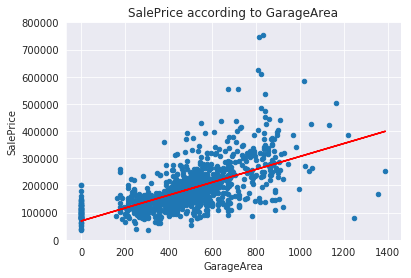

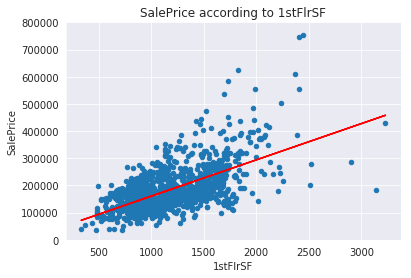

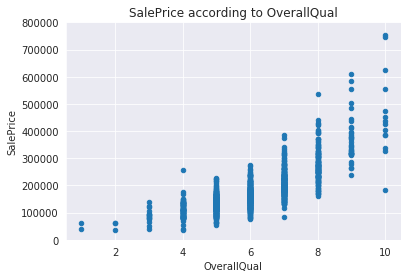

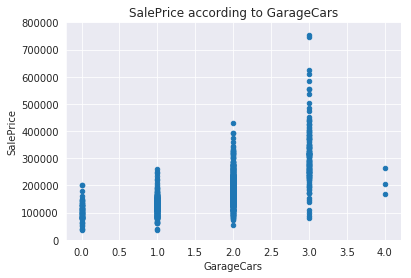

In [273]:
#visualisation of the relation between SalePrice and its most correlated columns
cols=['GrLivArea', 'TotalBsmtSF', 'GarageArea', '1stFlrSF'] #Take the most correlated columns
corr=[]
for k in cols:
    slope, intercept, r_value, p_value, std_err = stats.linregress(train[k], train['SalePrice']) #compute the slope and intercept for the linear regression model
    data = pd.concat([train['SalePrice'], train[k]], axis=1)
    data.plot.scatter(x=k, y='SalePrice', ylim=(0,800000))#draw the data points
    plt.plot(train[k], intercept + slope*train[k], 'r')#draw the estimated linear correlation
    plt.title('SalePrice according to ' + k)
    print(k, r_value) #print the correlation value
    
colsd=['OverallQual', 'GarageCars'] #discret values
corr=[]
for k in colsd:
    data = pd.concat([train['SalePrice'], train[k]], axis=1)
    data.plot.scatter(x=k, y='SalePrice', ylim=(0,800000))#draw the data points
    plt.title('SalePrice according to ' + k)    

<div class="alert alert-success">
        <b>
            Thanks to the visualisation, we see that the SalePrice is proprotionnal to its most correlated columns, which was intuitive. Furthermore, we see that the coefficient of correlation is around 0.7. The relationship between the SalePrice values and these columns can be modeled linearly.
        </b>
</div>

Id -0.019221749036144514
BsmtFinSF2 -0.0029196216554084153
LowQualFinSF -0.027071214891394534


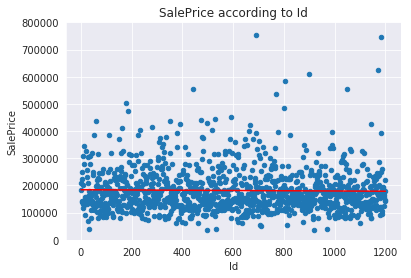

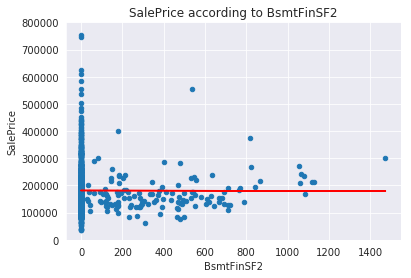

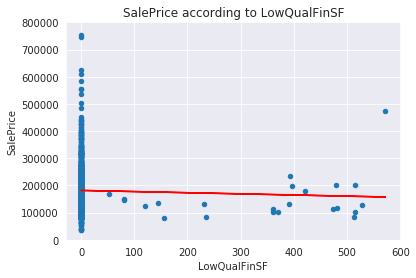

In [274]:
#visualisation of the relation between SalePrice and its least correlated columns
cols=['Id', 'BsmtFinSF2', 'LowQualFinSF'] #Take the least correlated columns with SalePrice
corr=[]
for k in cols:
    slope, intercept, r_value, p_value, std_err = stats.linregress(train[k], train['SalePrice'])
    data = pd.concat([train['SalePrice'], train[k]], axis=1)
    data.plot.scatter(x=k, y='SalePrice', ylim=(0,800000))
    plt.plot(train[k], intercept + slope*train[k], 'r')
    plt.title('SalePrice according to ' + k)
    print(k, r_value)

<div class="alert alert-success">
        <b>
           On the contrary, and as expected thanks to the correlation matrix, the visualisation of the SalePrice according to its least correlated columns shows us that there is no correlation between those data; the coefficient of correlation is around 0.
        </b>
</div>

<div class="">
    <h3>2. Data Pre-processing</h3>
</div>

The previous step should give you a better understanding of which pre-processing is required for the data.
This may include:

- Normalising and standardising the given data;
- Removing outliers;
- Carrying out feature selection, possibly using metrics derived from information theory;
- Handling missing information in the dataset;
- Augmenting the dataset with external information;
- Combining existing features.

<div class="alert alert-success">
        <b>
            To pre-process the data, we decided to follow the following strategy:<br>
            <li>  First, we want to get rid of the columns which don't bring a lot of information: we look at the ratio of missing values per columns and get rid of the columns which contains more than 50% of missing values.</li>
            <li>  Then, we want to get rid of repeated information: we look at the columns which are intercorrelated and get rid of the ones which are more than 80% correlated. To choose which columns we delete, we look at the correlation of columns with the SalePrice column. We delete the column which is the least correlated to SalePrice. </li>
            <li>After that, we fill missing values with estimated values or with the string "None".</li>
            <li>Also, we get rid of the column "Id" which is not related to our data.</li>
            NB: We do these steps for the train and the test datasets.<br>
        <br>Now we want to keep the best data for our model.
            <li> To do so, we get rid of the outliers we detected in the previous part (in the train dataset only).</li>
            <li>Also, we normalize the SalePrice distribution to reduce the skewness of our target values and thus, to get better accuracy with our regressions models in the 4th part (in the train dataset). We reduce the skewness of the training values to get better accurracy as well. Indeed, for data which can take a large range of values, this allows to give to each value the same impact on the target.</li>
             <li>Finally, we want to be able to use the data so we will use get_dummies to manage categorical values (in both the train and test datasets).</li>
            <li> Get_dummies will create new columns. Some won't be shared by the train and test datasets so we will get rid of them (except of the SalePrice column which only belongs to the train dataset).</li>
        </b>
</div>

<div class="alert alert-success">
        <b>
            This strategy has been chosen after different attempts:<br>
            We first tried to keep only the most correlated columns (threshold: >50%). We gave up on this idea because the results were really bad, we got rid of too much useful data with this strategy.<br>
            We then, decided to look at the result when we kept all the dataset: the results were better so we knew we had to keep a number of columns large enough. However, we didn't want to keep all the columns because some appeared useless and time consuming.
        </b>
</div>

<div class="alert alert-success">
    <h3>Getting rid of columns with lot of missing values</h3>
</div>

In [275]:
#Display the columns with the higher rate of missing values
train_na = (train.isnull().sum() / len(train)) * 100 #count the number of missing values
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)[:30]  #get rid of the column with no missing values
missing_data = pd.DataFrame({'Missing Ratio' :train_na}) #create the dataframe containing the column and its ratio of missing values
missing_data.head(6) #display the 6 first results of this detaframe

,Missing Ratio
PoolQC,99.666667
MiscFeature,96.083333
Alley,93.750000
Fence,81.083333
FireplaceQu,47.000000
LotFrontage,17.500000


<div class="alert alert-success">
        <b>
           We want to get rid of the columns which don't bring a lot of information. We decided to fix the threshold at 50% of missing values. Therefore, we delete the columns: PoolQC, MiscFeature, Alley and Fence in both the train and test dataset.
        </b>
</div>

In [276]:
#Get rid of these 4 columns
col = ['PoolQC','MiscFeature','Alley','Fence']
train.drop(col,axis=1,inplace=True) #get rid of those columns in the train dataset
test.drop(col,axis=1,inplace=True) #and in the test dataset

<div class="alert alert-success">
        <h3>Getting rid of intercorrelated columns</h3>
    </div>

In [277]:
#Display pairs of columns which are the most correlated
correlations=train.corr() #compute all the correlation of all columns
attrs = correlations.iloc[:-1,:-1] # all except target

threshold = 0.8 #set the threshold at 80%
important_corrs = (attrs[abs(attrs) > threshold][attrs != 1.0]) \
    .unstack().dropna().to_dict()

unique_important_corrs = pd.DataFrame(
    list(set([(tuple(sorted(key)), important_corrs[key]) \
    for key in important_corrs])), 
        columns=['Attribute Pair', 'Correlation'])

    # sorted by absolute value
unique_important_corrs = unique_important_corrs.loc[abs(unique_important_corrs['Correlation']).argsort()[::-1]]

unique_important_corrs

,Attribute Pair,Correlation
1,"(GarageArea, GarageCars)",0.885374
2,"(GarageYrBlt, YearBuilt)",0.838636
0,"(GrLivArea, TotRmsAbvGrd)",0.829755
3,"(1stFlrSF, TotalBsmtSF)",0.807276


<div class="alert alert-success">
        <b>
       We want to get rid of colums which repeat the same information, setting the threshold at 80% of correlation. To know which columns among the two we want to delete, we look at the correlation of the columns with SalePrice.
        </b>
</div>

In [278]:
#see the most correlated columns to the price to know which column to keep
corr=train.corr()["SalePrice"] #compute the correlation of the columns with the column SalePrice
corr[np.argsort(corr, axis=0)[::-1]][:16] #sort the previous list according to the computed correlation

SalePrice       1.000000
OverallQual     0.789142
GrLivArea       0.740379
TotalBsmtSF     0.641917
GarageCars      0.640961
GarageArea      0.623329
1stFlrSF        0.618556
FullBath        0.571867
TotRmsAbvGrd    0.559435
YearBuilt       0.523194
YearRemodAdd    0.509916
GarageYrBlt     0.489794
MasVnrArea      0.481406
Fireplaces      0.458528
BsmtFinSF1      0.407568
LotFrontage     0.378387
Name: SalePrice, dtype: float64

<div class="alert alert-success">
        <b>
      We see that GarageCars is more correlated with SalePrice than GarageArea; Thus we get rid of the columns GarageArea. We apply the same reasoning for the following columns and get rid of the columns GarageYrBlt, TotalBsmtSF and 1stFlrSF as well.
        </b>
</div>

In [279]:
#Get rid of these 4 columns
col = ['GarageArea','GarageYrBlt','TotRmsAbvGrd','1stFlrSF']
train.drop(col,axis=1,inplace=True) #get rid of those columns in the train dataset
test.drop(col,axis=1,inplace=True) #and in the test data

<div class="alert alert-success">
    <h3>Adding missing values to our columns</h3>
</div>

<div class="alert alert-success">
        <b>
      First, to know where we have to fill and which type of value we want to insert, let's take a look at the columns which contain missing values and the type of missing values. </b>
</div>

In [280]:
#Display the columns with the number of missing values and their type
nulls = np.sum(train.isnull())
nullcols = nulls.loc[(nulls != 0)]
dtypes = train.dtypes
dtypes2 = dtypes.loc[(nulls != 0)]
info = pd.concat([nullcols, dtypes2], axis=1).sort_values(by=0, ascending=False)
print(info)
print("There are", len(nullcols), "columns with missing values")

                0        1
FireplaceQu   564   object
LotFrontage   210  float64
GarageType     67   object
GarageFinish   67   object
GarageQual     67   object
GarageCond     67   object
BsmtExposure   33   object
BsmtFinType2   33   object
BsmtQual       32   object
BsmtCond       32   object
BsmtFinType1   32   object
MasVnrType      6   object
MasVnrArea      6  float64
There are 13 columns with missing values


<div class="alert alert-success">
        <b>
     To deal with missing values, we will change all the values of type object by the string "None".<br>
        For the values of type float64, we will turn them into 0 or a value we can figure out from present data.<br>
        For example, we can guss that, in the same neighborhood, the value of the linear feet of street connected to property (LotFrontage) will be quite the same for all the houses. Thus, we replace the missing values by the median of the values in the neighborhood. We see that, in some cases, there is no neighborhood. In this case, we replace the missing values by the mean.<br>
        On the contrary, it appears difficult to guess the value of Masonry veneer area (MasVnrArea), so by default we will replace these missing values by 0.</b>
</div>

In [281]:
#fill missing values of type object with "None"
for col in ('FireplaceQu','GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','BsmtExposure',
            'BsmtFinType2', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'MasVnrType'):
    train[col] = train[col].fillna('None')

#fill missing values with "0"
train['MasVnrArea'] = train['MasVnrArea'].fillna(0)

#Group by neighborhood and fill in missing valueBsmtFinSF by the median LotFrontage of all the neighborhood
train["LotFrontage"] = train.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [282]:
#We check all the data have been replaced
nulls = np.sum(train.isnull())
nullcols = nulls.loc[(nulls != 0)]
dtypes = train.dtypes
dtypes2 = dtypes.loc[(nulls != 0)]
info = pd.concat([nullcols, dtypes2], axis=1).sort_values(by=0, ascending=False)
print(info)
print("There are", len(nullcols), "columns with missing values")

Empty DataFrame
Columns: [0, 1]
Index: []
There are 0 columns with missing values


<div class="alert alert-success">
        <b>
     Let's operate in the same way for the test dataset.
        </b>
</div>

In [283]:
#Display the columns with the number of missing values and their type
nulls = np.sum(test.isnull())
nullcols = nulls.loc[(nulls != 0)]
dtypes = test.dtypes
dtypes2 = dtypes.loc[(nulls != 0)]
info = pd.concat([nullcols, dtypes2], axis=1).sort_values(by=0, ascending=False)
print(info)
print("There are", len(nullcols), "columns with missing values")

                0        1
FireplaceQu   126   object
LotFrontage    49  float64
GarageType     14   object
GarageFinish   14   object
GarageQual     14   object
GarageCond     14   object
BsmtQual        5   object
BsmtCond        5   object
BsmtExposure    5   object
BsmtFinType1    5   object
BsmtFinType2    5   object
MasVnrType      2   object
MasVnrArea      2  float64
Electrical      1   object
There are 14 columns with missing values


In [284]:
#fill missing values of type object with "None"
for col in ('FireplaceQu','GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','BsmtQual', 'BsmtCond',
            'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2','MasVnrType'):
    test[col] = test[col].fillna('None')

#fill missing values with "0"
test['MasVnrArea'] = test['MasVnrArea'].fillna(0)

#replace missing values of LotFrontage by the median of the values in the neighborhood
test["LotFrontage"] = test.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

#replace missing values of Electrical by the mode (the value which is the most present in the dataset)
test['Electrical'] = test['Electrical'].fillna(test['Electrical'].mode()[0])

In [285]:
#We check all the data have been replaced
nulls = np.sum(test.isnull())
nullcols = nulls.loc[(nulls != 0)]
dtypes = test.dtypes
dtypes2 = dtypes.loc[(nulls != 0)]
info = pd.concat([nullcols, dtypes2], axis=1).sort_values(by=0, ascending=False)
print(info)
print("There are", len(nullcols), "columns with missing values")

             0        1
LotFrontage  4  float64
There are 1 columns with missing values


<div class="alert alert-success">
        <b>
     We see that some data haven't been replaced. Indeed, some houses don't have neighborhood (probably they are located in the countryside). We will replace those by the mean of all the LotFrontage values.
        </b>
</div>

In [286]:
#some LotFrontage don't have neighborhood so we decided to take the mean of all the LotFrontage for these values
test["LotFrontage"] = test["LotFrontage"].fillna(test["LotFrontage"].mean())

In [287]:
#We check all the data have been replaced
nulls = np.sum(test.isnull())
nullcols = nulls.loc[(nulls != 0)]
dtypes = test.dtypes
dtypes2 = dtypes.loc[(nulls != 0)]
info = pd.concat([nullcols, dtypes2], axis=1).sort_values(by=0, ascending=False)
print(info)
print("There are", len(nullcols), "columns with missing values")

Empty DataFrame
Columns: [0, 1]
Index: []
There are 0 columns with missing values


<div class="alert alert-success">
    <h3>Getting rid of the column "Id" which is just a tool for us and has no impact on SalePrice</h3>
</div>

In [288]:
train.drop('Id',axis=1,inplace=True)
test.drop('Id',axis=1,inplace=True)

<div class="alert alert-success">
    <h3>Getting rid of some outliers</h3>
</div>

<div class="alert alert-success">
        <b>
     When we visualised the data, we saw that, among the most correlated columns we kept, there was an outlier in the GrLivArea. To increase a bit the performance, we get rid of this point.
        </b>
</div>

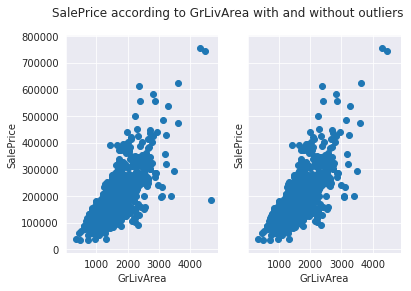

In [289]:
#Plot the initial graph
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
f.suptitle('SalePrice according to GrLivArea with and without outliers')

ax1.scatter(train['GrLivArea'], train['SalePrice'])
ax1.set(xlabel='GrLivArea', ylabel='SalePrice')
# ax1.set_title('SalePrice according to GrLivArea with outliers')

#Delete outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
ax2.scatter(train['GrLivArea'], train['SalePrice'])
ax2.set(xlabel='GrLivArea', ylabel='SalePrice')
# ax2.set_title('SalePrice according to GrLivArea without outliers')
plt.show()

<div class="alert alert-success">
    <h3>Normalising the data</h3>
</div>

<div class="alert alert-success">
    <b>
        Now, let's look at the distribution of the SalePrice values.
    </b>
</div>

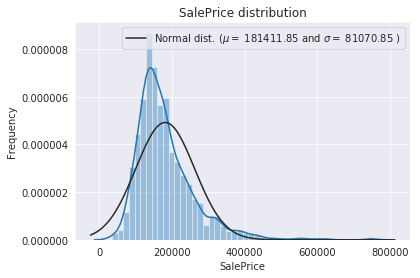

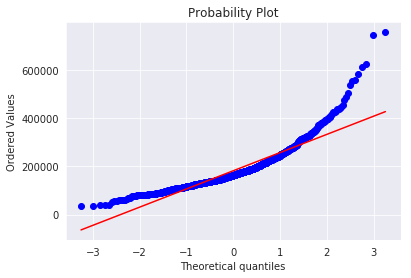

In [290]:
# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])

#Plot the distribution
sns.distplot(train['SalePrice'] , fit=norm);
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

<div class="alert alert-success">
    <b>
        We see that the SalePrice variable has almost a normal distribution but is shifted to the left. We want it to have a normal distribution to increase our regression model accuracy. Let's normalize the values.
    </b>
</div>

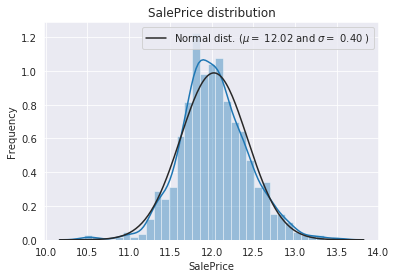

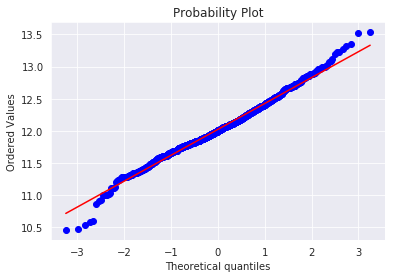

In [291]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

#Check the new distribution 
sns.distplot(train['SalePrice'], fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

<div class="alert alert-success">
    <h3>Decreasing the skewness of the data</h3>
</div>

In [292]:
from scipy.stats import skew

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in train.columns:
    if train[i].dtype in numeric_dtypes: 
        numerics2.append(i)

skew_features = train[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)
skews = pd.DataFrame({'skew':skew_features})
skews[:5]

,skew
MiscVal,28.028304
PoolArea,17.421080
LotArea,12.219429
3SsnPorch,10.104881
LowQualFinSF,8.503356


In [293]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
for i in train.columns:
    if (i !='SalePrice'):
        if train[i].dtype in numeric_dtypes: 
            train[i] = np.log1p(train[i])
for i in test.columns:
    if test[i].dtype in numeric_dtypes: 
        test[i] = np.log1p(test[i])

<div class="alert alert-success">
    <h3>Getting dummies</h3>
</div>

<div class="alert alert-success">
        <b>
    To be able to model, we have to convert string data into numerical data. <br>
    For example, SaleType can take the value "WD", "New" or "COD". Get_dummies will create three columns named with the string value and put 1 or 0 in each row so that we can use the data in the model.
        </b>
</div>

In [294]:
train = pd.get_dummies(train)

In [295]:
test = pd.get_dummies(test)

In [296]:
print("train shape:", train.shape)
print("test shape:", test.shape)

train shape: (1199, 274)
test shape: (260, 243)


<div class="alert alert-success">
        <b>
     We see now that we have 21 columns in the train dataset which don't appear in the test dataset, instead of just 1. This comes from the fact that some string values of the train dataset are not present in the test dataset.<br>
    In this special case of the lab, we don't expect to have more test datasets than this one so we will get rid of the columns which are only present in the train dataframe.
        </b>
</div>

<div class="alert alert-success">
    <h3>Getting rid of the unshared columns created by dummies</h3>
</div>

In [297]:
for k in train.columns:
    if (k != 'SalePrice') and ( k not in test.columns):
        train.drop(k,axis=1,inplace=True)

In [298]:
train.shape

(1199, 236)

<div class="alert alert-success">
        <b>
     Unexpectedly, we see that the number of remaining rows is lower than the row numbers of the test dataset. Some values were in the test dataset and not in the train dataset so we will get rid of these columns as well.
        </b>
</div>

In [299]:
for k in test.columns:
    if ( k not in train.columns):
        test.drop(k,axis=1,inplace=True)

In [300]:
test.shape

(260, 235)

<div class="alert alert-success">
        <b>
     Now, we are back in the case where the train dataset shares all its columns with the test dataset except the SalePrice column.
        </b>
</div>

<div class="alert alert-success">
    <h3>Curiosity: how are the graphs of SalePrice according to its most correlated columns after all those change?</h3>
</div>

GrLivArea 0.7488767198789305
TotalBsmtSF 0.367185741679927


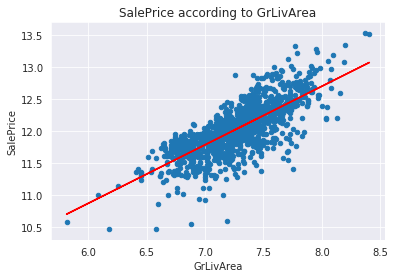

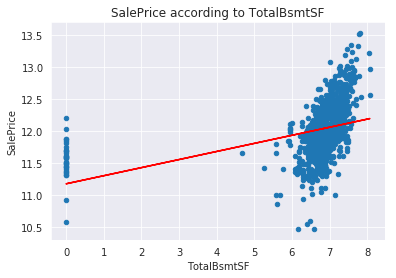

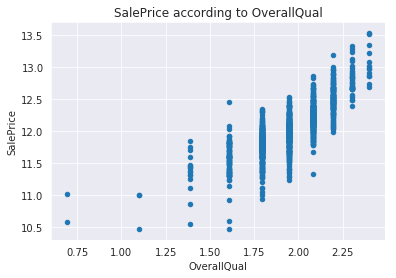

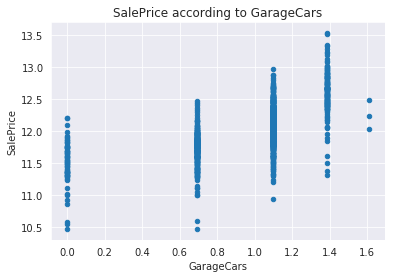

In [301]:
#visualisation of the relation between SalePrice and its most correlated columns
cols=['GrLivArea', 'TotalBsmtSF'] #'FullBath', 'YearBuilt','YearRemodAdd']
corr=[]
for k in cols:
    slope, intercept, r_value, p_value, std_err = stats.linregress(train[k], train['SalePrice'])
    data = pd.concat([train['SalePrice'], train[k]], axis=1)
    data.plot.scatter(x=k, y='SalePrice')
    plt.plot(train[k], intercept + slope*train[k], 'r')
    plt.title('SalePrice according to ' + k)
    print(k, r_value)

colsd=['OverallQual','GarageCars'] #'FullBath', 'YearBuilt','YearRemodAdd']
corr=[]
for k in colsd:
    data = pd.concat([train['SalePrice'], train[k]], axis=1)
    data.plot.scatter(x=k, y='SalePrice')
    plt.title('SalePrice according to ' + k)

<div class="alert alert-success">
    <b>
        We normalized our values. We see that the correlation has slightly increased compared to the first visualisation at the beginning of this lab.<br>
        </b>
</div>

<div class="alert alert-success">
    <h3>Finally, here is the dataset on which we will apply our model:</h3>
</div>

In [302]:
train[:6]

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_COD,SaleType_CWD,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.110874,4.189655,9.042040,2.079442,1.791759,7.602900,7.602900,5.283204,6.561031,0.0,...,0,0,0,0,1,0,0,0,1,0
1,3.044522,4.394449,9.169623,1.945910,2.197225,7.589336,7.589336,0.000000,6.886532,0.0,...,0,0,0,0,1,0,0,0,1,0
2,4.110874,4.234107,9.328212,2.079442,1.791759,7.601902,7.602401,5.093750,6.188264,0.0,...,0,0,0,0,1,0,0,0,1,0
3,4.262680,4.110874,9.164401,2.079442,1.791759,7.557995,7.586296,0.000000,5.379897,0.0,...,0,0,0,0,1,1,0,0,0,0
4,4.110874,4.442651,9.565284,2.197225,1.791759,7.601402,7.601402,5.860786,6.486161,0.0,...,0,0,0,0,1,0,0,0,1,0
5,3.931826,4.454347,9.555064,1.791759,1.791759,7.597898,7.598900,0.000000,6.597146,0.0,...,0,0,0,0,1,0,0,0,1,0


In [303]:
test[:6]

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_COD,SaleType_CWD,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,3.044522,4.276666,9.143559,1.609438,1.791759,7.586296,7.586296,0.000000,0.000000,0.000000,...,0,0,0,1,0,1,0,0,0,0
1,4.110874,4.394449,9.249657,2.079442,1.791759,7.600402,7.600402,0.000000,0.000000,0.000000,...,0,0,0,0,1,0,0,0,1,0
2,3.931826,3.931826,8.699681,1.791759,2.197225,7.563201,7.599902,0.000000,0.000000,0.000000,...,0,0,0,0,1,0,0,0,1,0
3,3.044522,4.330733,9.185125,2.079442,1.791759,7.601402,7.601902,5.147494,0.000000,0.000000,...,0,0,0,0,1,0,0,0,1,0
4,3.044522,4.369448,9.224342,1.791759,1.945910,7.588830,7.588830,0.000000,6.670766,0.000000,...,0,0,0,0,1,0,0,0,1,0
5,3.044522,4.510860,9.594582,2.079442,2.079442,7.596392,7.596894,5.459586,6.186209,5.181784,...,0,0,0,0,1,0,0,0,1,0


In [304]:
train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_COD,SaleType_CWD,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,...,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000
mean,3.819352,4.216348,9.108435,1.940631,1.867913,7.586850,7.593808,2.110810,4.254770,0.639753,...,0.030859,0.002502,0.083403,0.001668,0.864053,0.070892,0.009174,0.014178,0.816514,0.085905
std,0.691397,0.324910,0.518818,0.202604,0.171071,0.015307,0.010363,2.626959,2.976230,1.825212,...,0.173008,0.049979,0.276606,0.040825,0.342875,0.256752,0.095382,0.118276,0.387226,0.280341
min,3.044522,3.091042,7.170888,0.693147,0.693147,7.536897,7.576097,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.044522,4.110874,8.930759,1.791759,1.791759,7.578145,7.584773,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,3.931826,4.262680,9.151757,1.945910,1.791759,7.587817,7.598399,0.000000,5.955837,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,4.262680,4.394449,9.359794,2.079442,1.945910,7.601402,7.603399,5.117994,6.569481,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,5.252273,5.749393,12.279537,2.397895,2.302585,7.606387,7.606387,7.378384,7.691200,7.296413,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [305]:
test.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_COD,SaleType_CWD,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,...,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000
mean,3.815098,4.218270,9.116915,1.937061,1.875804,7.586621,7.593470,2.146489,4.100825,0.730066,...,0.023077,0.003846,0.080769,0.003846,0.888462,0.061538,0.003846,0.011538,0.842308,0.080769
std,0.676551,0.311435,0.504161,0.197811,0.155915,0.015780,0.010710,2.632037,3.064570,1.938758,...,0.150437,0.062017,0.273006,0.062017,0.315405,0.240779,0.062017,0.107002,0.365155,0.273006
min,3.044522,3.091042,7.335634,1.386294,1.386294,7.535297,7.576097,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.044522,4.110874,8.922792,1.791759,1.791759,7.576097,7.584265,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,3.931826,4.248495,9.169623,1.945910,1.791759,7.587057,7.597396,0.000000,5.888878,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,4.262680,4.394449,9.351536,2.079442,1.945910,7.602027,7.603399,5.081404,6.559194,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,5.252273,5.749393,11.064887,2.397895,2.302585,7.605890,7.605890,6.680855,8.638525,6.939254,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [306]:
# train.shape

In [307]:
# test.shape

<div class="">
    <h3>3. Model Selection</h3>
</div>

Perhaps the most important segment of this challenge involves the selection of a model that can successfully handle the given data and yield sensible predictions.
Instead of focusing exclusively on your final chosen model, it is also important to share your thought process in this notebook by additionally describing alternative candidate models.
There is a wealth of models to choose from, such as <i>decision trees</i>, <i>random forests</i>, <i>(Bayesian) neural networks</i>, <i>Gaussian processes</i>, <i>LASSO regression</i>, and so on.
There are several factors which may influence your decision:

- What is the model's complexity?
- Is the model interpretable?
- Is the model capable of handling different data-types?
- Does the model return uncertainty estimates along with predictions?

An in-depth evaluation of competing models in view of this and other criteria will elevate the quality of your submission and earn you a higher grade.


<div class="alert alert-success">
    <h3>Explanation of our choice of regression models</h3>
</div>

<div class="alert alert-success">
    <b>
We decided to choose Regression, because it is the most commonly used method for forecasting, and this is the case for this lab, where the goal is te be able to predict the selling price. Also, our target is continuous so the regression models were attractive. Finally, this method is not computationnally expensive compared to other models and easier to understand, which is atttractive at the beginning.<br>
It is important to note that regression is somehow related to classification, but they are different.<br>
Classification forecasts whether something will happen, while regression forecasts how much something will happen.<br><br>
For the regression we decided to use the following techniques :<br><br>
        1- Lasso (Least Absolute Shrinkage and Selection Operator) : it's a shrinkage and variable selection method for linear regression models, where the goal is to be able to obtain a subset of predictors that minimizes the error, it does this by imposing a constraint for some variables to shrink toward zero, we call it L1 Regularization.<br>
        We think it's going to be very important because we have a big number of features, and this technique shrinks the less important feature’s coefficient to zero.<br>
        The larger the value of alpha, the more features are shrunk to zero.<br>
        We can see in this picture the effect of alpha in the shrinkage of the features :<br>
        source : https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c<br>
    </b>
</div>       

![title](picture5.PNG)

<div class="alert alert-success">
    <b>
2- Ridge : This model works like Lasso, but uses L2 Regularization.<br>
        The Ridge regressor helps to decrease the complexity of the model by shrinking the effect of the features, but does reduce the number 
        of features like Lasso.<br>
        This is L2 Regularization term :<br>
        source : https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c<br><br>
    </b>
</div>       

![title](picture4.PNG)

<div class="alert alert-success">
    <b>
3- ElasticNet : it's a combination of L1 and L2 regularization, ElasticNet tend to select more variables compared to Lasso for example, and therefore it leadsto larger models, even if it's computationally expensive it's more accurate in general.<br>
For example when Lasso selects randomly one of the two very correlated features, ElasticNet will be likely to pick both of them to have a more stable model.<br>
    </b>
</div>    

<div class="alert alert-success">
        <b>
            We didn't use decision trees because the problem here is a problem of forecasting. Decision tree algorithms are mainly used for classification since they aim at attributing a group to the inputs. There is a lock of smoothness and the result depends highly on the split input features.
            We could afford linear regression (thanks to linear dependancy) which will be more precise than decision trees algorithms.
        </b>
</div>

<div class="alert alert-success">
        <b>
We could have used Random Forest as well. This algorithm is based on the decision tree concept and average the predictions of the subtrees, bagging the result. Even if it would have made more precise predictions than a simple decision tree, we didn't used it neither, preferring exploring and getting advantages of the linear dependancy.
        </b>
</div>

<div class="alert alert-success">
    <h3>Importing libraries</h3>
</div>

<div class="alert alert-success">
    <b>
        Let's import the useful libraries.
    </b>
</div> 

In [308]:
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

<div class="alert alert-success">
    <h3>Isolating the SalePrice column from the train dataset</h3>
</div>

<div class="alert alert-success">
    <b>
Now, we will split our training dataset in order to separate the SalePrice which is what we have to predict and the input variables
    </b>
</div> 

In [309]:
y_train = train.SalePrice.values

In [310]:
train.drop(['SalePrice'],axis=1,inplace=True)

<div class="alert alert-success">
    <h3>Splitting our data for the training phase</h3>
</div>

<div class="alert alert-success">
    <b>
This part is very important because we wanted to make sure that our models won't overfit. In order to do so, we decided to take 90% for training data and keep the last 10% until the end and see how well our final model will perform on some data that has never been seen from the beginning, by comparing the predictions and the real values.
        This way of working will help us to avoid completely any chance of "data leakage" and therefore "overfit" as well.  
    </b>
</div> 

In [311]:
train,train_test,y_train,y_test = train_test_split(train,y_train,shuffle=True,test_size=0.10)

<div class="">
    <h3>4. Parameter Optimisation</h3>
</div>

Irrespective of your choice, it is highly likely that your model will have one or more parameters that require tuning.
There are several techniques for carrying out such a procedure, including cross-validation, Bayesian optimisation, and several others.
As before, an analysis into which parameter tuning technique best suits your model is expected before proceeding with the optimisation of your model.

<div class="alert alert-success">
    <h3>Looking for the best hyperparameters</h3>
</div>

<div class="alert alert-success">
    <b>
    Now that we have chosen our models, we want to evaluate how they perform, we are going to follow these steps:<br>
        1- We will tune the hyperparameters of the estimators by using GridSearchCV.<br>
        2- We will evaluate how well a given estimator performs on the dataset by using cross_val_score from sklearn.model_selection.<br>
    </b>
</div> 

<div class="alert alert-success">
    <b>
    GridSearchCV :<br><br>
        This method will help us to know which is the best value to set for the hyperparameters of the model, and for a better performance of the genralization performance, we will use cross-validation to evaluate the performance of each hyperparameter combination.<br><br>
        Sometimes when the model contains lot of hyperparameters to solve, it may become computationally expensive to evaluate all the combinations, it can be useful to start with a small set and then according to the results, we expand our search.<br><br>
        In our case, it is fortunately not very complex because for the Lasso model we only have the alpha to set and same thing goes for ElasticNet. The alpha parameter allows us to manipulate feature coefficients: if alpha is close to 0, we get the same coefficient as for a linear regression. On the contrary, the higher alpha is, the more we get 0 as coefficients (thus, when alpha increases, the number of features which will be considered decreases).<br>KernelRidge is a bit more complex but we will not show all the details of applying the GridSearchCV on all the models.
        We will show how it works on the Lasso model.<br>
        NB : there is a library called spark-sklearn and it contains GridSearchCV(), we could have used it to see how it performs when the jobs are parallelized, but we didn't have enough time to perform it.<br>
    </b>
</div> 

In [312]:
grid = GridSearchCV( Lasso(), {'alpha': [0,10**(-8),0.0004,0.0005, 0.001,0.01, 0.1, 0.5, 1]}, verbose=3)
grid.fit(train.values, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] alpha=0 .........................................................
[CV] ................ alpha=0, score=0.8884213669161821, total=   0.5s
[CV] alpha=0 .........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] ................ alpha=0, score=0.8960290387541331, total=   0.5s
[CV] alpha=0 .........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV] ................ alpha=0, score=0.8775924599914118, total=   0.5s
[CV] alpha=1e-08 .....................................................
[CV] ............ alpha=1e-08, score=0.8884285216026421, total=   0.5s
[CV] alpha=1e-08 .....................................................
[CV] ............ alpha=1e-08, score=0.8960270787975351, total=   0.5s
[CV] alpha=1e-08 .....................................................
[CV] ............ alpha=1e-08, score=0.8776030617769726, total=   0.5s
[CV] alpha=0.0004 ....................................................
[CV] ........... alpha=0.0004, score=0.9120157590454675, total=   0.0s
[CV] alpha=0.0004 ....................................................
[CV] ........... alpha=0.0004, score=0.9088363221008992, total=   0.1s
[CV] alpha=0.0004 ....................................................
[CV] ........... alpha=0.0004, score=0.9082453153233667, total=   0.2s
[CV] alpha=0.0005 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    4.3s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0, 1e-08, 0.0004, 0.0005, 0.001, 0.01, 0.1, 0.5, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

<div class="alert alert-success">
    <b>
    Now that the test is finished, let's print the results to see which value of alpha is the best suitable for our training data
    </b>
</div> 

   mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
0       0.522403         0.000619         0.887357          0.958974   
1       0.499388         0.000649         0.887362          0.958974   
2       0.072104         0.017182         0.909700          0.944635   
3       0.084728         0.003232         0.910423          0.942476   
4       0.057275         0.032821         0.909849          0.934002   
5       0.019629         0.017660         0.843048          0.854481   
6       0.008857         0.017710         0.393387          0.400375   
7       0.005876         0.000824        -0.004939          0.000000   
8       0.006257         0.002738        -0.004939          0.000000   

  param_alpha             params  rank_test_score  split0_test_score  \
0           0       {'alpha': 0}                5           0.888421   
1       1e-08   {'alpha': 1e-08}                4           0.888429   
2      0.0004  {'alpha': 0.0004}                3           0.9

Text(0,0.5,'mean_test_score')

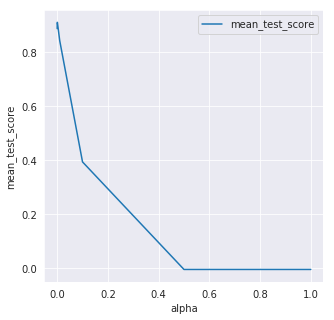

In [313]:
#This was done to not print some warnings that are not useful in our case
import warnings
warnings.filterwarnings('ignore')
#We convert the results into a dataframe and print them
df = pd.DataFrame(grid.cv_results_)
df["alpha"] = df.params.apply(lambda x: x["alpha"])
print(df)
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot()
df.set_index("alpha")[["mean_test_score"]].plot(ax=ax)
ax.set_xlabel("alpha")
ax.set_ylabel("mean_test_score")

<div class="alert alert-success">
    <b>
    Each line refers to one value of alpha, the results of cross validation are recorded too, as well as the mean and the standard deviation.<br>
    We can see that the best value for alpha is 0.0005, and it's indeed ranked as the best one in the "rank_test_score" column.<br>
    For ElasticNet and KernelRidge we will do the same thing and not show the whole code for it (very big). 
    </b>
</div> 

<div class="alert alert-success">
    <h3>Avoiding overfitting: Cross validation</h3>
</div>

<div class="alert alert-success">
    <b>
        Cross-validation is a statistical method that helps us to evaluate the performance of a model, it is more stable than just a train/test split.<br>
        The technique used the most is the k-fold cross validation, where k is specified by the user and usually between 5 and 10.<br>
        This method is known to avoid overfitting on the test set, we call it "data leakage". It happens when knowledge about the test set leaks into the model and evaluation metrics. To avoid this, the cross_val_score partitions our dataset into three partitions, the first two are for estimation and validation, and the last one is kept to calculate a performance measure.<br>
        Let's keep in mind that cross-validation is not a way to build a model that can be applied to new data, it does not return a model, it's just a way to evaluate how well a given algorithm will generalize when trained on a specific dataset.<br>
        This is a picture that shows how cross-validation on performs on a dataset :<br>
        source : https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation
    </b>
</div> 

![title](picture1.PNG)

In [314]:
#We set the number of folds we want to do for the K-Fold Cross Validation
n_folds = 5

#This function will compute for us the mean squared error between the logarithms of the target and the predicted value
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf, n_jobs=-1))
    return(rmse)

<div class="alert alert-success">
    <b>
    We set n_jobs to -1, it means that we want to use all the processors and we will have jobs running in parrallel.<br>
    We will actually have 4 jobs running in parrallel because we have 4 cores available, according to the student quota in Zoe
    </b>
</div> 

<div class="alert alert-success">
    <h3>Increasing robustness of the models</h3>
</div>

In [315]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0004))

In [316]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0004, l1_ratio=.9))

In [317]:
ridge = make_pipeline(RobustScaler(), Ridge(alpha =0.0004))

<div class="alert alert-success">
    <b>
To make our model more robusts, we decided to use a pipeline for Lasso and ElasticNet and apply RobustScaler() which will make the models more robust to outliers.<br>
Knowing that the function cross_val_score returns an array containing five values, we will print the mean of these values and also the standard deviation to have an idea if there's an overfit on a specific fold or not.<br>
NB : We have tested the first two models without a pipeline and the scores (errors) were a bit higher than with a pipeline, which is not what we want.<br>
    </b>
</div> 

<div class="alert alert-success">
    <h3>Computing the scores (mean_squared_error)</h3>
</div>

In [318]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1194 (0.0058)



In [319]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1198 (0.0060)



In [320]:
score = rmsle_cv(ridge)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1374 (0.0110)



<div class="alert alert-success">
    <b>
We can see that we have some pretty good results using the models above, now we will try to do some optimization by averaging these models.
    </b>
</div> 

<div class="alert alert-success">
    <h3>Averaging the models to get better results</h3>
</div>

In [321]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [322]:
averaged_models = AveragingModels(models = (ENet,lasso, ridge))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1208 (0.0049)



<div class="alert alert-success">
    <b>
The score is a bit lower than any of the single models, and this is good, so averaging the models helped us to make a much more better score.
    </b>
</div> 

<div class="">
    <h3>5. Model Evaluation</h3>
</div>

Some form of pre-evaluation will inevitably be required in the preceding sections in order to both select an appropriate model and configure its parameters appropriately.
In this final section, you may evaluate other aspects of the model such as:

- Assessing the running time of your model;
- Determining whether some aspects can be parallelised;
- Training the model with smaller subsets of the data.
- etc.

<div class="alert alert-danger">
    <b>N.B.</b> Please note that the items listed under each heading are neither exhaustive, nor are you expected to explore every given suggestion.
    Nonetheless, these should serve as a guideline for your work in both this and upcoming challenges.
    As always, you should use your intuition and understanding in order to decide which analysis best suits the assigned task.
</div>

<div class="alert alert-success">
    <b>
Beforehand, we will define a function that computes the mean squared error :<br>
    </b>
</div> 

In [323]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

<div class="alert alert-success">
    <h3>Training</h3>
</div>

In [324]:
#We train our last model on the training set (it represents 90% of the whole dataset)
t0 = time()
averaged_models.fit(train.values, y_train)
print("Training took %.2f seconds"% (time()-t0))

#We make predictions on train set
train_pred = averaged_models.predict(train.values)

#THIS IS WHERE WE MAKE THE PREDICTIONS ON THE TEST SET THAT HAS NEVER BEEN SEEN BEFORE
pred = averaged_models.predict(train_test.values)

#We compute the results on the training set
score_training = rmsle(y_train, train_pred)

#We compute the results on the test set
score_test = rmsle(y_test, pred)

#PRINT
print("The score on the training set: {:.4f} \n".format(score_training))
print("The score on the test set: {:.4f}\n".format(score_test))

Training took 0.17 seconds
The score on the training set: 0.0937 

The score on the test set: 0.0995



<div class="alert alert-success">
    <b>
Just like what we were expecting, the results on the test set are a little bit worst than on the training set, and this is normal, and the score is quite good (0.0075)
    </b>
</div> 

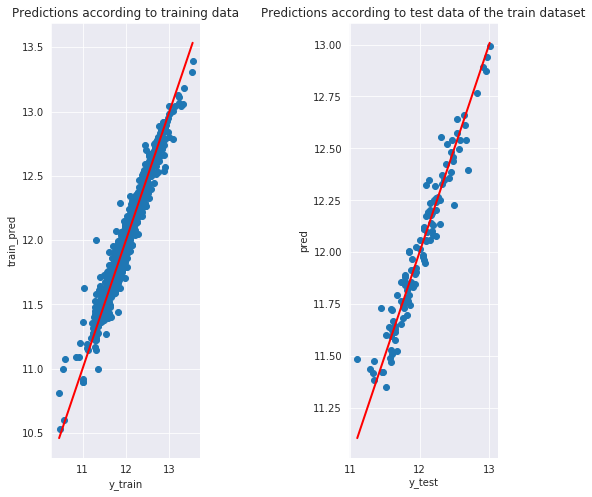

In [331]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(8,8))
plt.gcf().subplots_adjust(wspace = 1)
ax1.scatter(y_train, train_pred)
ax1.plot([min(y_train),max(y_train)], [min(y_train), max(y_train)], 'r-', lw=2) # Red straight line
ax1.set_title('Predictions according to training data')
ax1.set(xlabel='y_train', ylabel='train_pred')

ax2.scatter(y_test, pred)
ax2.plot([min(y_test),max(y_test)], [min(y_test), max(y_test)], 'r-', lw=2) # Red straight line
ax2.set_title('Predictions according to test data of the train dataset')
ax2.set(xlabel='y_test',ylabel='pred')
plt.show()

<div class="alert alert-success">
    <b>
        We see that we have some error but on average, the prediction is closed to the real value. We are now ready to predict new values.
    </b>
</div> 

In [263]:
pred_values = averaged_models.predict(test.values)

## Getting our SalePrice estimation
Final_labels = np.expm1(pred_values)

<div class="">
    <h2>Submission Instructions</h2>
    <hr style="height:1px;border:none;color:#333;background-color:#333;" />    
</div>

- The goal of this challenge is to construct a model for predicting house prices;
<br><br>

- Your submission will have two components:

    1. An <b>HTML version of your notebook</b> exploring the various modelling aspects described above;
    2. A CSV file containing your <b>final model's predictions on the given test data</b>. 
       This file should contain a header and have the following format:
       
        ```
        Id,SalePrice
        1461,169000.1
        1462,187724.1233
        1463,175221
        etc.
        ```
        
        An example submission file has been provided in the data directory of the repository.
        A leaderboard for this challenge will be ranked using the root mean squared error between the logarithm of the predicted value and the logarithm of the observed sales price. 
        Taking logs ensures that errors in predicting expensive houses and cheap houses will have a similar impact on the overall result;
<br><br>
- This exercise is due on <b>04/04/2019</b>.

In [332]:
## Saving to CSV
submission=pd.DataFrame({'Id':[i for i in range(1461,1461+len(Final_labels))],'SalePrice': Final_labels})  

submission.to_csv("final_submission.csv", index=False)

<h3><b>Sources</b></h3>

https://www.kaggle.com/laurenstc/top-2-of-leaderboard-advanced-fe?fbclid=IwAR2pReWnMhgzU1b0eySNVuk6EYP70W66uzyxbJ7G0EEQK6mfWuNNn1FrXv4<br><br>
https://www.kaggle.com/neviadomski/how-to-get-to-top-25-with-simple-model-sklearn<br><br>
https://www.kaggle.com/poonaml/house-prices-data-exploration-and-visualisation<br><br>
https://dzone.com/articles/decision-trees-vs-clustering-algorithms-vs-linear<br><br>